In [1]:

import os
import fnmatch
import numpy as np
import torch
from tqdm import tqdm
import random
import json
import matplotlib.pyplot as plt
import re
# from dual_network import Dual3DCNN6 as Dual
from decayLR import DecayLR
import torch
from torch.utils.data import Dataset
import SimpleITK as sitk
import numpy as np
import glob
from utilities import create_list_from_master_json, read_json_file, split_data
from torch.utils.data import Dataset, DataLoader



IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


Epochs: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
Training Losses: [0.4753391517099933, 0.3570865272918594, 0.3035822491570611, 0.2853565905765395, 0.2742955837677294, 0.27902333929299195, 0.26812077407664225, 0.27559017724244395, 0.2723451519959441, 0.26766324830110944, 0.265229743809622, 0.26946132468216333, 0.2668135089921617, 0.27062941774308125, 0.2665401470856132, 0.2671706431379942, 0.2670039783153578, 0.26581778937828876, 0.2684890837452122, 0.26383612374557514, 0.264288611292282, 0.26490572373443677, 0.266975467589414, 0.2660188750477038]
Validation Losses: [0.24492906980654772, 0.24332060261684305, 0.2420047179741018, 0.24217988533132218, 0.24299033634802875, 0.24162966004189323, 0.2437684248037198, 0.24230873172774034, 0.24296296519391677, 0.24448447727105196, 0.24332022123477037, 0.2441432419945212, 0.24399858634261523, 0.24417247123578015, 0.24436647217063343, 0.24572793718646554, 0.2444992994560915, 0.2442500561475754, 0.24423

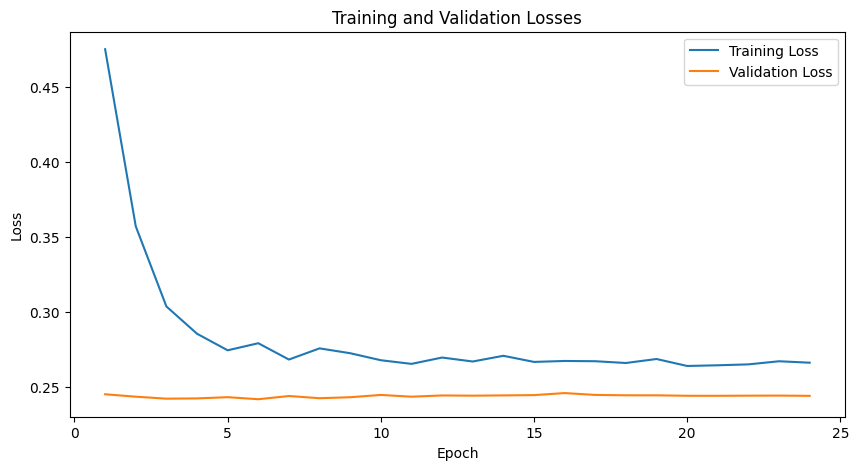

In [2]:
import matplotlib.pyplot as plt
import re

# Path to the loss file
loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG/128_1ctP_0.0001_[32, 64, 128].txt'
loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG/256_1ctP_0.0001_[32, 64, 128].txt'
loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG/128_1ctP_0.0001_[8, 16, 32].txt'
loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG/128_1ctP_0.01_[8, 16, 32].txt'
loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG/128_1ctP_0.01_[16, 32, 64].txt'
loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG/128_1ctP_0.01_[16, 32, 64, 128].txt'
loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG/128_1ctP_0.0001_[16, 32, 64, 128]_L1L2(4).txt'
loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG/128_1ctP_0.0001_[16, 32, 64, 128]_L1L2(5).txt'
loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG/128_1ctP_1e-05_[16, 32, 64, 128]_L1L2(5).txt'
loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG/128_1ctP_0.0001_[32, 64, 128, 256]_L1L2(4).txt'
loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG_CT/cnn4_512_0.0001_L1L2(5)_sn.txt'





epochs = []
training_losses = []
validation_losses = []

with open(loss_file_path, 'r') as file:
    for line in file:
        match_epoch = re.search(r'Epoch: (\d+)/\d+, Loss: (\d+\.\d+), Val: (\d+\.\d+)', line)
        if match_epoch:
            epochs.append(int(match_epoch.group(1)))
            training_losses.append(float(match_epoch.group(2)))
            validation_losses.append(float(match_epoch.group(3)))


print("Epochs:", epochs)
print("Training Losses:", training_losses)
print("Validation Losses:", validation_losses)

# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(epochs, training_losses, label='Training Loss')
plt.plot(epochs, validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()


Epochs: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Training Losses: [0.8869136918690943, 0.757476114157942, 0.7148226987282258, 0.7030611289554232, 0.6995941211380774, 0.6979534963833257, 0.7001255170353466, 0.6968175123578736, 0.6947415169505846, 0.6980644213202011, 0.6934671934605354, 0.6994788038566531, 0.6973418386741763, 0.6961309640180497, 0.6965211341601043, 0.6941949676145756, 0.6924575367454617, 0.6952506856482831, 0.6936336262151599, 0.6940615191567867, 0.6950131054368934, 0.6937454713430876, 0.6946182005229362, 0.6942369124763423, 0.6946801724123015, 0.6922101850421833, 0.6953164896528635, 0.6937794691461715, 0.6917615384306937, 0.6928423094297094]
Validation Losses: [0.6640150164637495, 0.660055908027525, 0.6591044692505225, 0.6588203023900004, 0.6579385544447338, 0.6554193253464559, 0.6545909617424888, 0.6574338764755749, 0.6554256063319889, 0.6567635681918439, 0.6562377638092228, 0.6567195665602591, 0.65

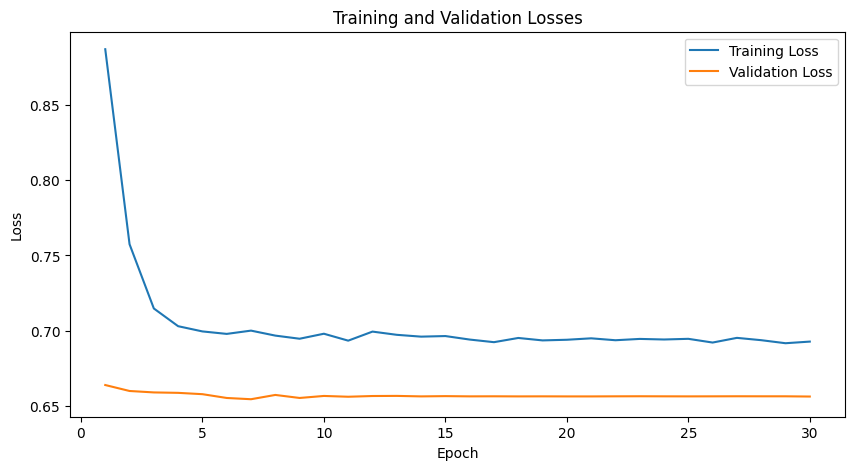

In [55]:
import matplotlib.pyplot as plt
import re

# # Path to the loss file
# loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG/128_1ctP_0.0001_[32, 64, 128].txt'
# loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG/256_1ctP_0.0001_[32, 64, 128].txt'
# loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG/128_1ctP_0.0001_[8, 16, 32].txt'
# loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG/128_1ctP_0.01_[8, 16, 32].txt'
# loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG/128_1ctP_0.01_[16, 32, 64].txt'
# loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG/128_1ctP_0.01_[16, 32, 64, 128].txt'
# loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG/128_1ctP_0.0001_[16, 32, 64, 128]_L1L2(4).txt'
# loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG/128_1ctP_0.0001_[16, 32, 64, 128]_L1L2(5).txt'
# loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG/128_1ctP_1e-05_[16, 32, 64, 128]_L1L2(5).txt'
loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG_opt/128_1optP_0.0001_[32, 64, 128, 256]_L1L2(4).txt'
loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG_opt/128_1optP_0.001_[8, 16, 32].txt'
loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG_opt/128_1optP_0.001_[8, 16, 32]_L1L2(4).txt'
loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG_opt/128_1optP_0.0001_[8, 16, 32]_L1L2(4).txt'
loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG_opt/128_1optP_0.0001_[16, 32, 64]_L1L2(4).txt'
loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG_opt/128_1optP_0.0001_[16, 32, 64, 128]_L1L2(4).txt'
loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG_opt/128_1optP_0.0001_[16, 32, 64, 128, 256]_L1L2(4).txt'
loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG_opt/128_1optP_0.01_[16, 32, 64, 128, 256]_L1L2(4).txt'
loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG_opt/128_1optP_1e-05_[16, 32, 64, 128, 256]_L1L2(6).txt'
loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG_opt/128_1optP_1e-05_[32, 64, 128, 256, 512]_L1L2(6).txt'
loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG_opt/128_1optP_0.0001_CNN4_L1L2(4).txt'
loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG_opt/128_1optP_0.0001_[16, 32, 64, 128]_L1L2(5).txt'



epochs = []
training_losses = []
validation_losses = []

with open(loss_file_path, 'r') as file:
    for line in file:
        match_epoch = re.search(r'Epoch: (\d+)/\d+, Loss: (\d+\.\d+), Val: (\d+\.\d+)', line)
        if match_epoch:
            epochs.append(int(match_epoch.group(1)))
            training_losses.append(float(match_epoch.group(2)))
            validation_losses.append(float(match_epoch.group(3)))


print("Epochs:", epochs)
print("Training Losses:", training_losses)
print("Validation Losses:", validation_losses)

# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(epochs, training_losses, label='Training Loss')
plt.plot(epochs, validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()


Epochs: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Training Losses: [1.898640925278429, 1.9031574528236859, 1.9058689420503345, 1.904778367793951, 1.9055556228903474, 1.9045082320525346, 1.9016951448534913, 1.9007536189966514, 1.9004311181048443, 1.8982697371820934, 1.8964555323257177, 1.8962817459565695, 1.8955819613733629, 1.896120464738973]
Validation Losses: [2.159090409676234, 2.1573603683047824, 2.156475954585605, 2.1562194757991366, 2.154590520593855, 2.155866665972604, 2.1554317308796778, 2.154677265220218, 2.155730197827021, 2.156843980153402, 2.157086511452993, 2.1571365793546042, 2.15747168329027, 2.157504422797097]


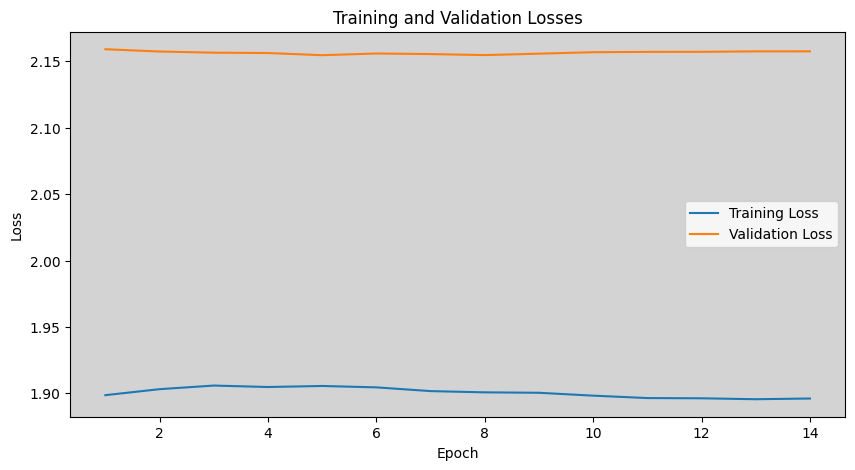

In [213]:
import matplotlib.pyplot as plt
import re

# # Path to the loss file
loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG_3f/128_1optP_0.0001_CNN6_L1L2(6).txt'
loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG_3f/128_1optP_1e-05_CNN6_L1L2(6).txt'
loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG_3f/128_1optP_0.0001_CNN6_L1L2(5).txt'
loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG_3f/128_1optP_0.0001_CNN6_L1L2(4).txt'
loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG_3f_1ct/128_1ctP_0.01_[16, 32, 64].txt'
loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG_3f_1ct/128_1ctP_0.01_[16, 32, 64, 128].txt'
loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG_3f_1ct/128_1ctP_0.0001_[16, 32, 64, 128].txt'
loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG_3f_1ct/128_1ctP_0.0001_[16, 32, 64, 128]_L1L2(4).txt'
loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG_3f_1ct/128_1ctP_0.0001_[16, 32, 64, 128]_L1L2(5).txt'
loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG_3f_1ct/128_1ctP_1e-05_[16, 32, 64, 128]_L1L2(5).txt'
loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG_3f_1ct/128_1ctP_0.0001_[32, 64, 128, 256]_L1L2(4).txt'




epochs = []
training_losses = []
validation_losses = []

with open(loss_file_path, 'r') as file:
    for line in file:
        match_epoch = re.search(r'Epoch: (\d+)/\d+, Loss: (\d+\.\d+), Val: (\d+\.\d+)', line)
        # match_epoch = re.search(r'Epoch: (\d+)/\d+, *Loss: (\d+\.\d+), *Val Loss: (\d+\.\d+)', line)

        if match_epoch:
            epochs.append(int(match_epoch.group(1)))
            training_losses.append(float(match_epoch.group(2)))
            validation_losses.append(float(match_epoch.group(3)))


print("Epochs:", epochs)
print("Training Losses:", training_losses)
print("Validation Losses:", validation_losses)

# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(epochs, training_losses, label='Training Loss')
plt.plot(epochs, validation_losses, label='Validation Loss')

# Set the background color inside the plot area
plt.gca().set_facecolor('lightgrey')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()


Epochs: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
Training Losses: [0.7219541208611594, 0.666963806665606, 0.633729069493711, 0.6312281412382921, 0.6322482265532017, 0.6297186812592878, 0.6247848089163502, 0.6238803149511417, 0.6236845694068406, 0.6235540737294488, 0.624446152564552, 0.6244465105235577, 0.624061421594686, 0.6247806955335868, 0.621386982086632, 0.6246146714521779, 0.6236499127207531, 0.6234448341445791, 0.6229487406917744, 0.6241694235967266, 0.623710915280713, 0.6243841210897598, 0.6233139910424749, 0.6228857509791851, 0.623247697411312, 0.6216548909536667, 0.6243516454266177, 0.6219016315932903, 0.6238280943698353, 0.622955537463228, 0.6234115582787328, 0.622044480426444, 0.6238462541252374, 0.6244796464840571, 0.6236510684506761, 0.6237204635929731, 0.624780494781832, 0.6219043181174331, 0.6210329941577382, 0.6228488882

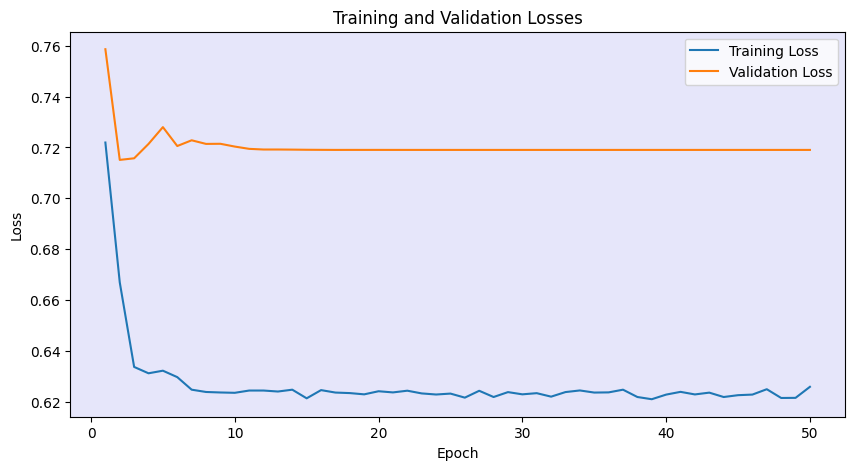

In [48]:

import matplotlib.pyplot as plt
import re

# Path to the loss file
loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG_oneone/128_11P_0.0001_[32, 64, 128].txt'
loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG_oneone/128_11P_0.0001_[32, 64, 128, 256].txt'
loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG_oneone/128_11P_1e-05_[16, 32, 64, 128].txt'
loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG_oneone/128_11P_0.0001_[16, 32, 64, 128].txt'
loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG_oneone/128_11P_0.01_[16, 32, 64, 128].txt'

# loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG/128_1ctP_0.01_[8, 16, 32].txt'
# loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG/128_1ctP_0.01_[16, 32, 64].txt'
# loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG/128_1ctP_0.01_[16, 32, 64, 128].txt'
# loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG/128_1ctP_0.0001_[16, 32, 64, 128]_L1L2(4).txt'
# loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG/128_1ctP_0.0001_[16, 32, 64, 128]_L1L2(5).txt'
# loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG/128_1ctP_1e-05_[16, 32, 64, 128]_L1L2(5).txt'


epochs = []
training_losses = []
validation_losses = []

with open(loss_file_path, 'r') as file:
    for line in file:
        match_epoch = re.search(r'Epoch: (\d+)/\d+, Loss: (\d+\.\d+), Val: (\d+\.\d+)', line)
        if match_epoch:
            epochs.append(int(match_epoch.group(1)))
            training_losses.append(float(match_epoch.group(2)))
            validation_losses.append(float(match_epoch.group(3)))


print("Epochs:", epochs)
print("Training Losses:", training_losses)
print("Validation Losses:", validation_losses)

# Plot the losses
plt.figure(figsize=(10, 5))
plt.gca().set_facecolor('lavender')
plt.plot(epochs, training_losses, label='Training Loss')
plt.plot(epochs, validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()


--------------------

Epochs: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220,

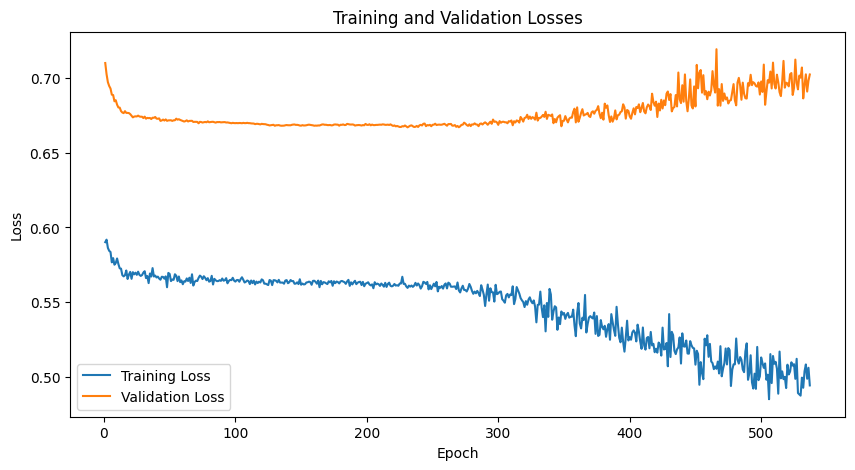

In [82]:
import matplotlib.pyplot as plt
import re

# Path to the loss file
loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG/model_128_all.txt'

epochs = []
training_losses = []
validation_losses = []

with open(loss_file_path, 'r') as file:
    for line in file:
        match_epoch = re.search(r'Epoch: (\d+)/\d+, Loss: (\d+\.\d+), Val: (\d+\.\d+)', line)
        if match_epoch:
            epochs.append(int(match_epoch.group(1)))
            training_losses.append(float(match_epoch.group(2)))
            validation_losses.append(float(match_epoch.group(3)))


print("Epochs:", epochs)
print("Training Losses:", training_losses)
print("Validation Losses:", validation_losses)

# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(epochs, training_losses, label='Training Loss')
plt.plot(epochs, validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()


Epochs: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220,

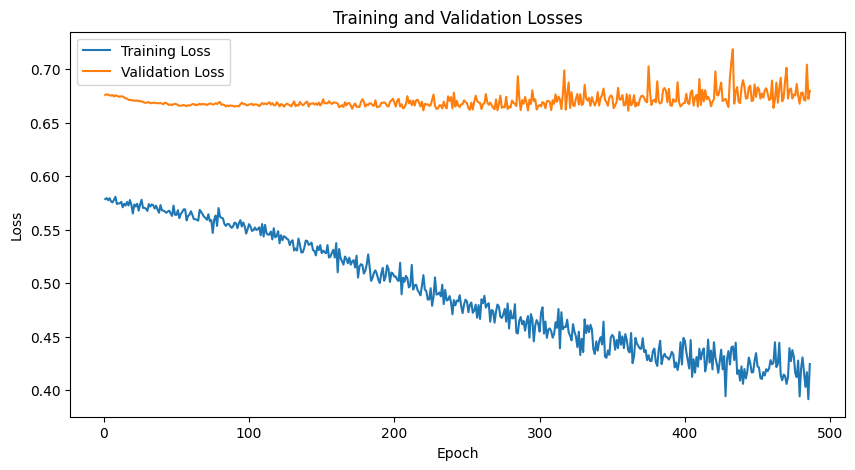

In [102]:
import matplotlib.pyplot as plt
import re

# Path to the loss file
loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG/model_128_all_opt.txt'

epochs = []
training_losses = []
validation_losses = []

with open(loss_file_path, 'r') as file:
    for line in file:
        match_epoch = re.search(r'Epoch: (\d+)/\d+, Loss: (\d+\.\d+), Val: (\d+\.\d+)', line)
        if match_epoch:
            epochs.append(int(match_epoch.group(1)))
            training_losses.append(float(match_epoch.group(2)))
            validation_losses.append(float(match_epoch.group(3)))


print("Epochs:", epochs)
print("Training Losses:", training_losses)
print("Validation Losses:", validation_losses)

# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(epochs, training_losses, label='Training Loss')
plt.plot(epochs, validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()


Epochs: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220,

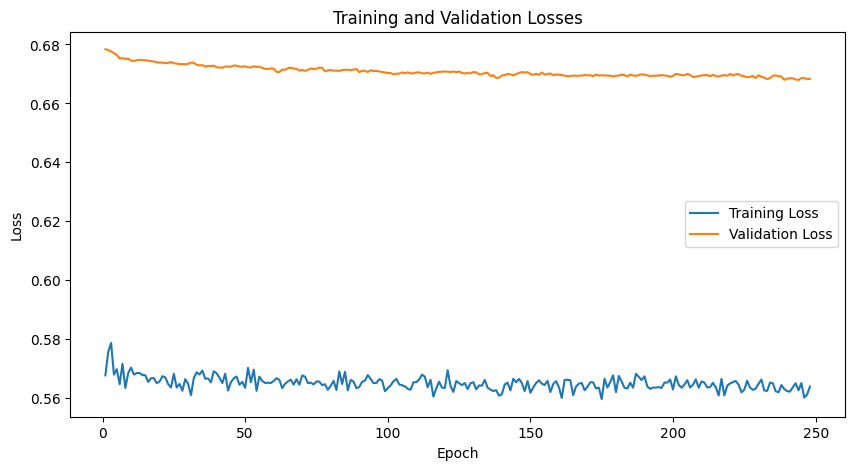

In [124]:

import matplotlib.pyplot as plt
import re

# Path to the loss file
loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG/model_128_all_opt_simplemodel.txt'

epochs = []
training_losses = []
validation_losses = []

with open(loss_file_path, 'r') as file:
    for line in file:
        match_epoch = re.search(r'Epoch: (\d+)/\d+, Loss: (\d+\.\d+), Val: (\d+\.\d+)', line)
        if match_epoch:
            epochs.append(int(match_epoch.group(1)))
            training_losses.append(float(match_epoch.group(2)))
            validation_losses.append(float(match_epoch.group(3)))


print("Epochs:", epochs)
print("Training Losses:", training_losses)
print("Validation Losses:", validation_losses)

# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(epochs, training_losses, label='Training Loss')
plt.plot(epochs, validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()


Epochs: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220,

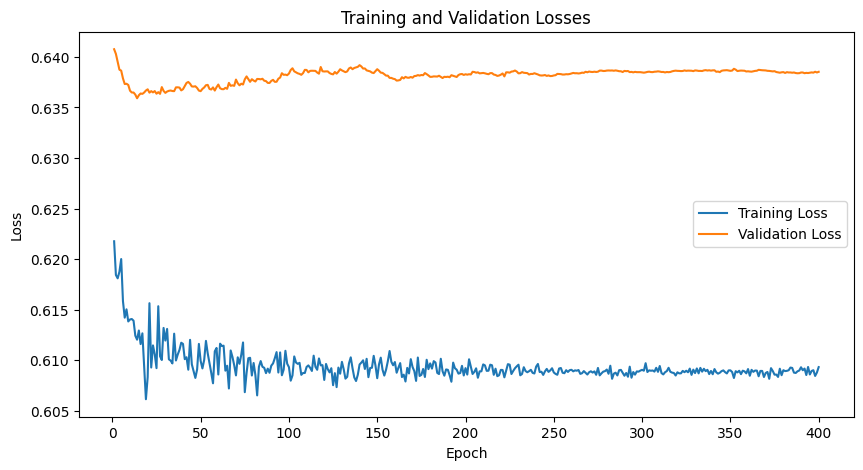

In [131]:


import matplotlib.pyplot as plt
import re

# Path to the loss file
loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG/model_128_all_opt_simplemodel_newsortdatabiggerlr.txt'

epochs = []
training_losses = []
validation_losses = []

with open(loss_file_path, 'r') as file:
    for line in file:
        match_epoch = re.search(r'Epoch: (\d+)/\d+, Loss: (\d+\.\d+), Val: (\d+\.\d+)', line)
        if match_epoch:
            epochs.append(int(match_epoch.group(1)))
            training_losses.append(float(match_epoch.group(2)))
            validation_losses.append(float(match_epoch.group(3)))


print("Epochs:", epochs)
print("Training Losses:", training_losses)
print("Validation Losses:", validation_losses)

# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(epochs, training_losses, label='Training Loss')
plt.plot(epochs, validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()


Epochs: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
Training Losses: [0.18451146874576807, 0.19297877419739962, 0.1776538724079728, 0.17589762853458524, 0.16924171103164554, 0.18089062627404928, 0.16739305201917887, 0.15985356364399195, 0.1611616425216198, 0.15986777981743217, 0.15658534178510308, 0.16716107912361622, 0.17009882535785437, 0.15869010239839554, 0.1488516889512539, 0.1623658398166299, 0.15911647770553827, 0.15963404206559062, 0.1570001421496272, 0.15243535209447145, 0.15018235938623548, 0.14290554402396083, 0.1453412752598524, 0.15107546700164676, 0.14933023834601045, 0.1381708332337439, 0.15176424011588097, 0.1493829321116209, 0.15019749151542783, 0.14542636647820473, 0.14892042614519596, 0.1465606801211834, 0.14990553632378578, 0.14319363282993436, 0.14792660530656576, 0.14484847942367196, 0.14547143038362265, 0.147835755720

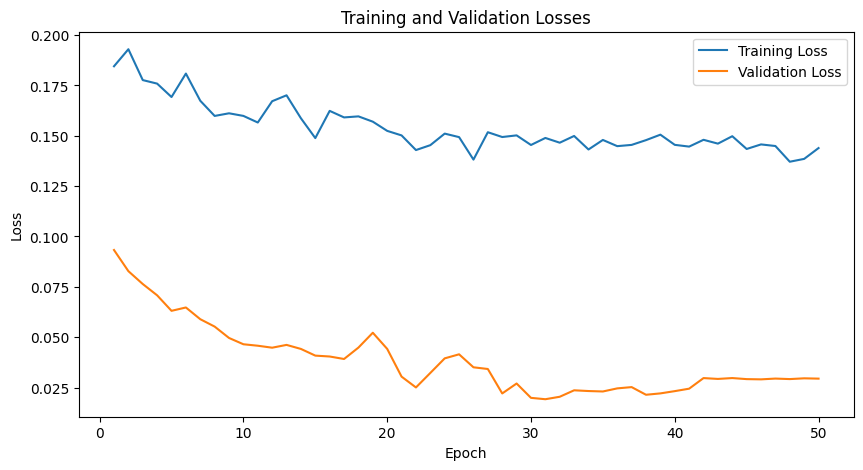

In [27]:


import matplotlib.pyplot as plt
import re

# Path to the loss file
loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG/model_128_all_opt_deepermodel.txt'
loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG/model_128_all2_opt_deepermodel.txt'
loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG/model_128_morepatient.txt'
loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG/model_128_morepatient_optuna.txt'
loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG/model_128_morepatient_optuna2.txt'
loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG/model_128_morepatient2.txt'
loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG/model_1rCT.txt'

epochs = []
training_losses = []
validation_losses = []

with open(loss_file_path, 'r') as file:
    for line in file:
        match_epoch = re.search(r'Epoch: (\d+)/\d+, Loss: (\d+\.\d+), Val: (\d+\.\d+)', line)
        if match_epoch:
            epochs.append(int(match_epoch.group(1)))
            training_losses.append(float(match_epoch.group(2)))
            validation_losses.append(float(match_epoch.group(3)))


print("Epochs:", epochs)
print("Training Losses:", training_losses)
print("Validation Losses:", validation_losses)

# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(epochs, training_losses, label='Training Loss')
plt.plot(epochs, validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()


Epochs: []
Training Losses: []
Validation Losses: []


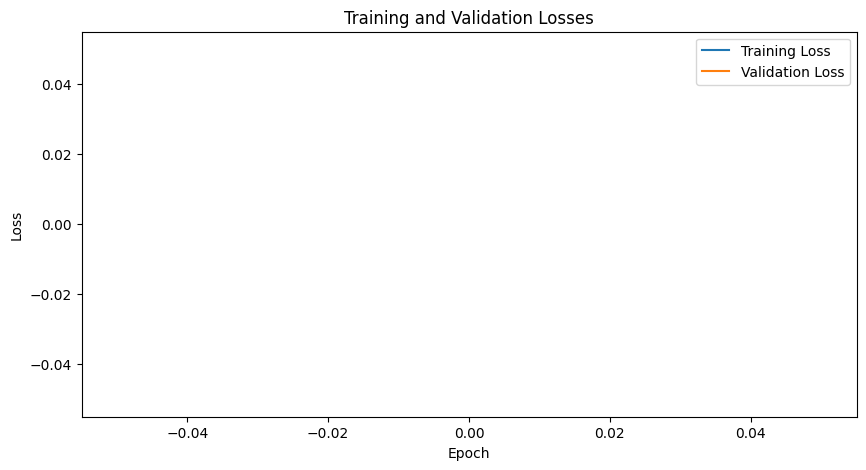

In [4]:
# import matplotlib.pyplot as plt
# import re

# # Path to the loss file
# # loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG/dg.txt'
# loss_file_path ='/home/shahpouriz/Data/DBP_Project/LOG/loss_Model_3f_newopt.txt'
# loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG/loss_Model_3f_newopt_morebatches.txt'
# loss_file_path = '/home/shahpouriz/Data/DBP_Project/LOG/loss_128_lessp.txt'

# epochs = []
# training_losses = []
# validation_losses = []

# # Open the loss file and read the lines
# with open(loss_file_path, 'r') as file:
#     for line in file:
#         # Adjust the regex pattern to match the file's format
#         # The regex now allows for optional spaces around the commas
#         match_epoch = re.search(r'Epoch: (\d+)/\d+, *Loss: (\d+\.\d+), *Val Loss: (\d+\.\d+)', line)
#         if match_epoch:
#             epochs.append(int(match_epoch.group(1)))
#             training_losses.append(float(match_epoch.group(2)))
#             validation_losses.append(float(match_epoch.group(3)))

# print("Epochs:", epochs)
# print("Training Losses:", training_losses)
# print("Validation Losses:", validation_losses)

# # Plot the losses
# plt.figure(figsize=(10, 5))
# plt.plot(epochs, training_losses, label='Training Loss')
# plt.plot(epochs, validation_losses, label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training and Validation Losses')
# plt.legend()
# plt.show()


In [4]:
from utilities import list_patient_folders, prepare_data_nrrd, split_data

# Specify the directory where the patient folders are located
# data_path_NEW = '/home/shahpouriz/Data/DBP_newDATA/DBP/nrrd/proton'
# data_path_OLD = '/home/shahpouriz/Data/DBP_oldDATA/nrrd/proton'
data_path_OLD = '/home/shahpouriz/Data/DBP_oldDATA/nrrd/test'
data_path_NEW = '/home/shahpouriz/Data/DBP_newDATA/DBP/nrrd/test'

# Get the list of patient folders

patient_list_NEW = list_patient_folders(data_path_NEW)
pct, rct, pos = prepare_data_nrrd(data_path_NEW, patient_list_NEW)
data_NEW = [{"plan": img[0], "repeat": tar, "pos": pos} for img, tar, pos in zip(pct, rct, pos)]


patient_list_OLD = list_patient_folders(data_path_OLD)
pct, rct, pos = prepare_data_nrrd(data_path_OLD, patient_list_OLD)
data_OLD = [{"plan": img[0], "repeat": tar, "pos": pos} for img, tar, pos in zip(pct, rct, pos)]


# Assuming data_NEW and data_OLD are your lists of dictionaries
data = data_NEW + data_OLD
# data = data_NEW[:20] + data_OLD[:20]

# Split the data
_, val_data, test_data = split_data(data)

# Check the lengths of the sets
# print("Number of training samples:", len(train_data))
print("Number of validation samples:", len(val_data))
print("Number of test samples:", len(test_data))

# train_files, val_files = data_dicts[:18], data_dicts[18:]


Number of validation samples: 56
Number of test samples: 57


In [7]:
#### My method

from monai.transforms import Compose, LoadImaged, ScaleIntensityd, EnsureChannelFirstd, Spacingd, SpatialPadd, CenterSpatialCropd, ScaleIntensityRanged
from monai.data import CacheDataset, DataLoader, Dataset
from monai.transforms import LoadImaged
from monai.data.image_reader import ITKReader

dim = 128
pixdim = (2.0, 2.0, 2.0)
size = (dim, dim, dim)
transforms = Compose([
        LoadImaged(keys=["plan", "repeat"], reader=ITKReader()),
        
        EnsureChannelFirstd(keys=["plan", "repeat"]),
        ScaleIntensityd(keys=["plan", "repeat"]),
        Spacingd(keys=["plan", "repeat"], pixdim=pixdim, mode='trilinear'),
        SpatialPadd(keys=["plan", "repeat"], spatial_size=size, mode='constant'),  # Ensure minimum size
        CenterSpatialCropd(keys=["plan", "repeat"], roi_size=size),  # Ensure uniform size
    ])


val_ds = CacheDataset(data=val_data, transform=transforms, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4)

test_ds = CacheDataset(data=test_data, transform=transforms, cache_rate=1.0, num_workers=4)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=4)



Loading dataset: 100%|██████████| 57/57 [00:07<00:00,  7.96it/s]


In [13]:
import torch
from dual_network import Dual3DCNN6 as Dual

device = torch.device("cuda:0")
saved_model_path = '/home/shahpouriz/Data/DBP_Project/LOG/model_128_5.pt'
# saved_model_path = '/home/shahpouriz/Data/DBP_Project/LOG/loss_simple_Model_256_mse_7.pt'

model = Dual(width=dim, height=dim, depth=dim)  # Assuming the model architecture is Dual
model.load_state_dict(torch.load(saved_model_path))
model.to(device)  # Make sure to move the model to the appropriate device (CPU or GPU)




Dual3DCNN6(
  (input_fixed_blocks): ModuleList(
    (0): Sequential(
      (0): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): Conv3d(16, 16, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (2): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (1): Sequential(
      (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): Conv3d(32, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (2): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (2): Sequential(
      (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): Conv3d(64, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [14]:

# Evaluate the model on the test set
import torch
from torch.nn.functional import mse_loss

# Assuming `test_loader` is your DataLoader for the test set
model.eval()  # Set model to evaluation mode
total_mae = 0.0
total_samples = 0

with torch.no_grad():  # No need to calculate gradients
    for batch_data in test_loader:
        # Load data and model predictions
        pCT_test, rCT_test = batch_data["plan"].to(device), batch_data["repeat"].to(device)
        reg_test = batch_data["pos"].to(device)  # Assuming 'pos' is your ground truth
        
        output_test = model(pCT_test, rCT_test)
        
        # Calculate MAE between output and ground truth
        mae = torch.abs(output_test - reg_test).mean()
        total_mae += mae.item() * pCT_test.size(0)  # Multiply by batch size for correct average
        total_samples += pCT_test.size(0)
    
    # Calculate average MAE across all test samples
    average_mae = total_mae / total_samples
    print(f"Average MAE on Test Set: {average_mae}")

Average MAE on Test Set: 1.8983532002097683


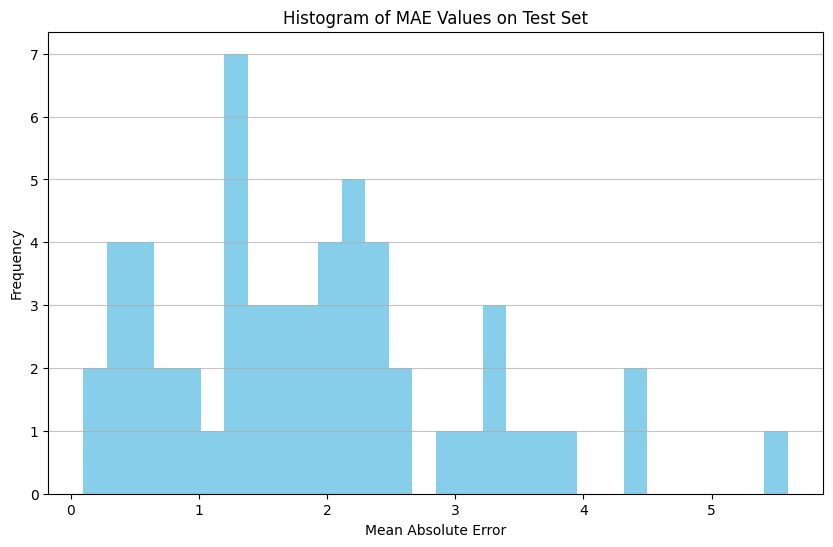

In [15]:
import matplotlib.pyplot as plt
import torch

model.eval()  # Set model to evaluation mode
mae_values = []  # List to store individual MAE values

with torch.no_grad():  # No need to calculate gradients
    for batch_data in test_loader:
        pCT_test, rCT_test = batch_data["plan"].to(device), batch_data["repeat"].to(device)
        reg_test = batch_data["pos"].to(device)  # Ground truth coordinates
        
        output_test = model(pCT_test, rCT_test)
        
        # Calculate MAE for each item in the batch and store it
        mae = torch.abs(output_test - reg_test).mean(dim=1)  # Calculate MAE for each sample
        mae_values.extend(mae.cpu().numpy())  # Store the MAE values

# Plotting the histogram of MAE values
plt.figure(figsize=(10, 6))
plt.hist(mae_values, bins=30, color='skyblue')
plt.title('Histogram of MAE Values on Test Set')
plt.xlabel('Mean Absolute Error')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

plt.show()


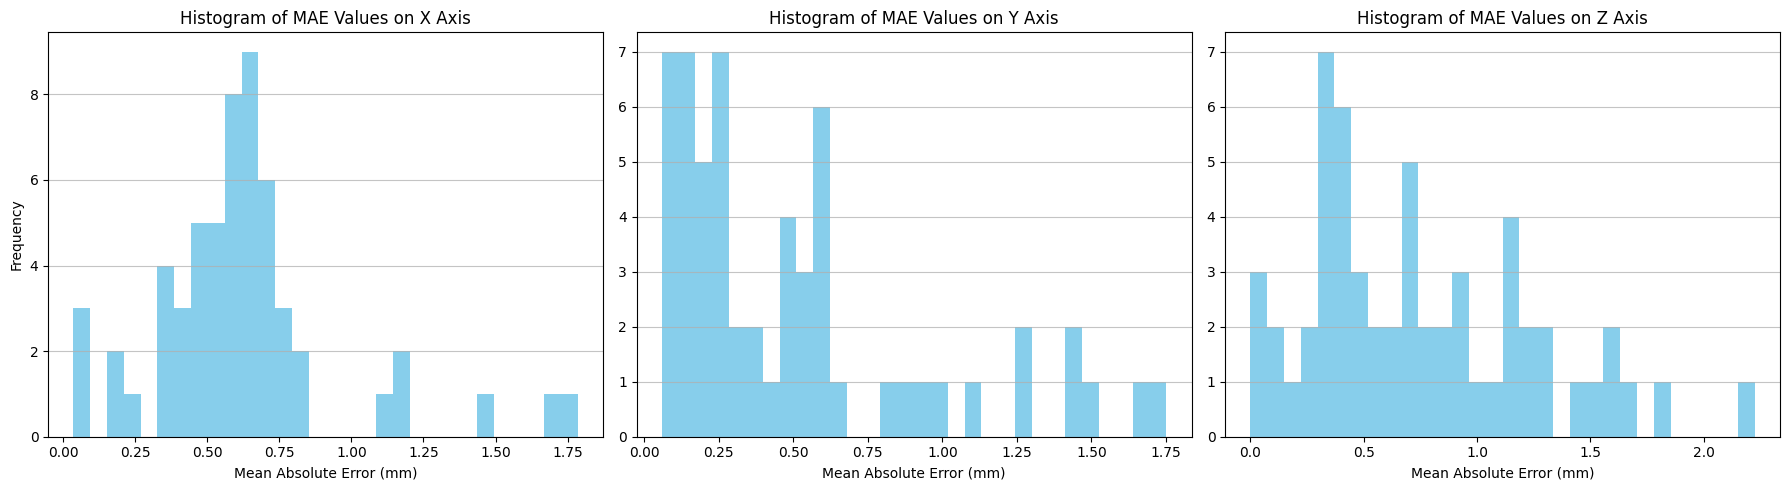

In [11]:
import matplotlib.pyplot as plt
import torch

model.eval()  # Set model to evaluation mode
mae_values_x, mae_values_y, mae_values_z = [], [], []  # Lists to store individual MAE values for each axis

with torch.no_grad():  # No need to calculate gradients
    for batch_data in test_loader:
        pCT_test, rCT_test = batch_data["plan"].to(device), batch_data["repeat"].to(device)
        reg_test = batch_data["pos"].to(device)  # Ground truth coordinates
        
        output_test = model(pCT_test, rCT_test)
        
        # Calculate MAE for each axis and store it
        mae_x = torch.abs(output_test[:, 0] - reg_test[:, 0])  # MAE for x axis
        mae_y = torch.abs(output_test[:, 1] - reg_test[:, 1])  # MAE for y axis
        mae_z = torch.abs(output_test[:, 2] - reg_test[:, 2])  # MAE for z axis
        
        mae_values_x.extend(mae_x.cpu().numpy())
        mae_values_y.extend(mae_y.cpu().numpy())
        mae_values_z.extend(mae_z.cpu().numpy())

# Plotting the histogram of MAE values for each axis
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.hist(mae_values_x, bins=30, color='skyblue')
plt.title('Histogram of MAE Values on X Axis')
plt.xlabel('Mean Absolute Error (mm)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

plt.subplot(1, 3, 2)
plt.hist(mae_values_y, bins=30, color='skyblue')
plt.title('Histogram of MAE Values on Y Axis')
plt.xlabel('Mean Absolute Error (mm)')
plt.grid(axis='y', alpha=0.75)

plt.subplot(1, 3, 3)
plt.hist(mae_values_z, bins=30, color='skyblue')
plt.title('Histogram of MAE Values on Z Axis')
plt.xlabel('Mean Absolute Error (mm)')
plt.grid(axis='y', alpha=0.75)

plt.tight_layout()
plt.show()


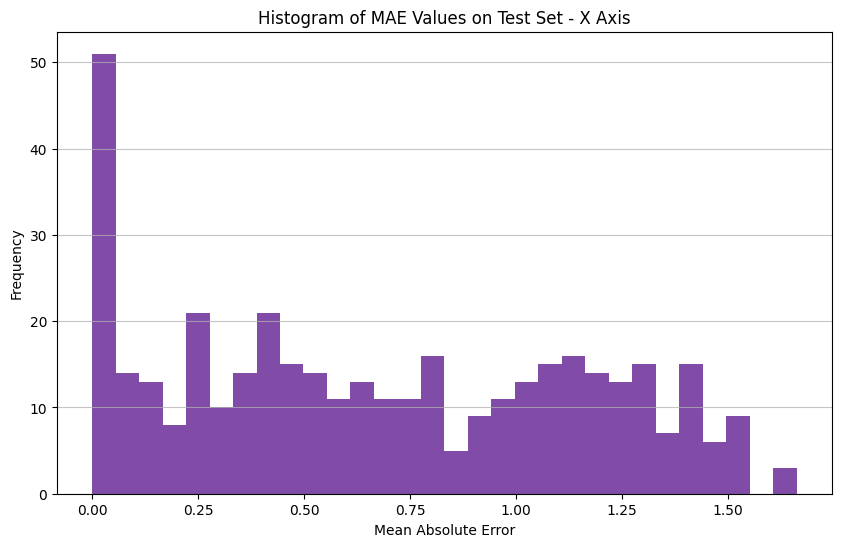

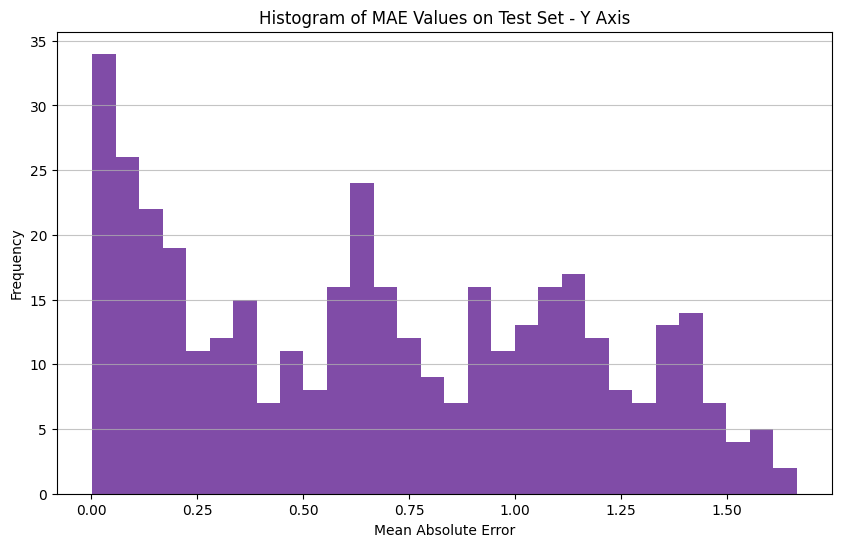

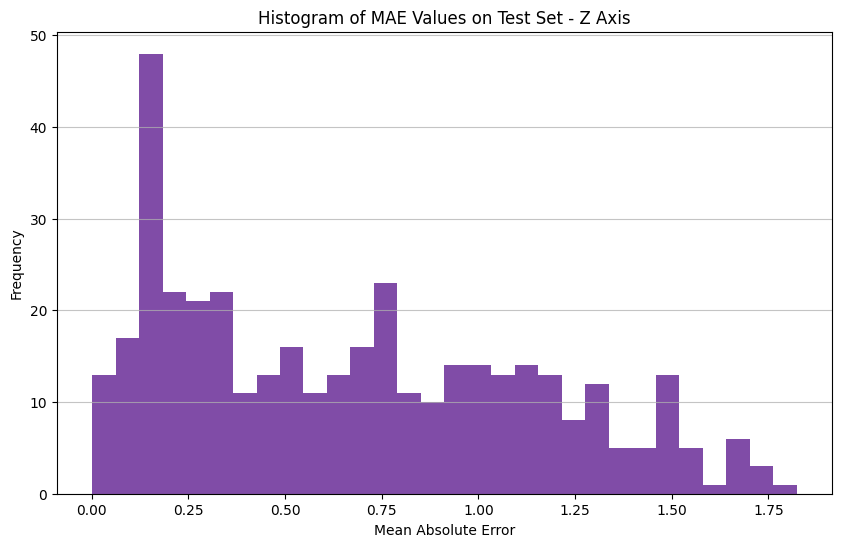

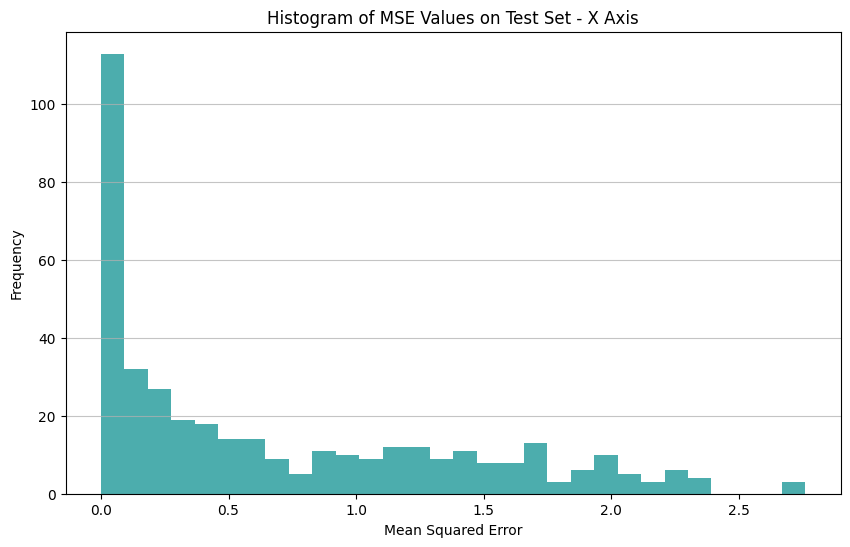

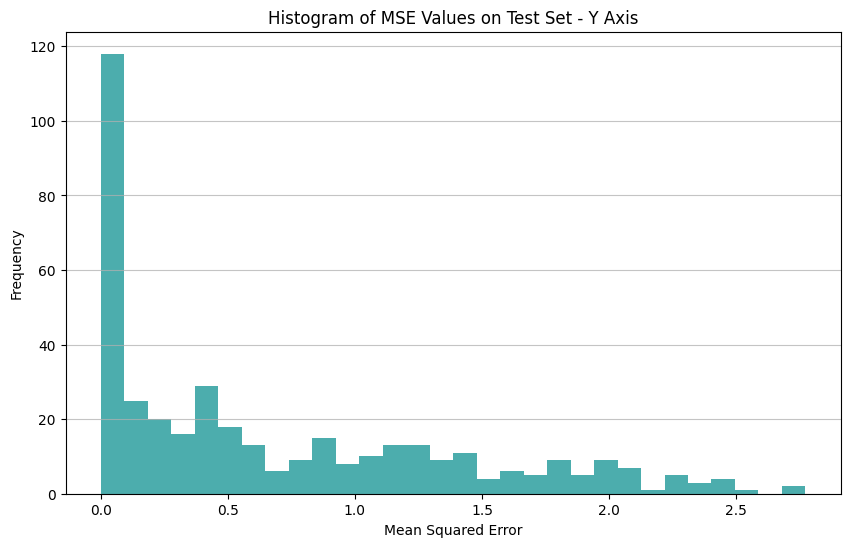

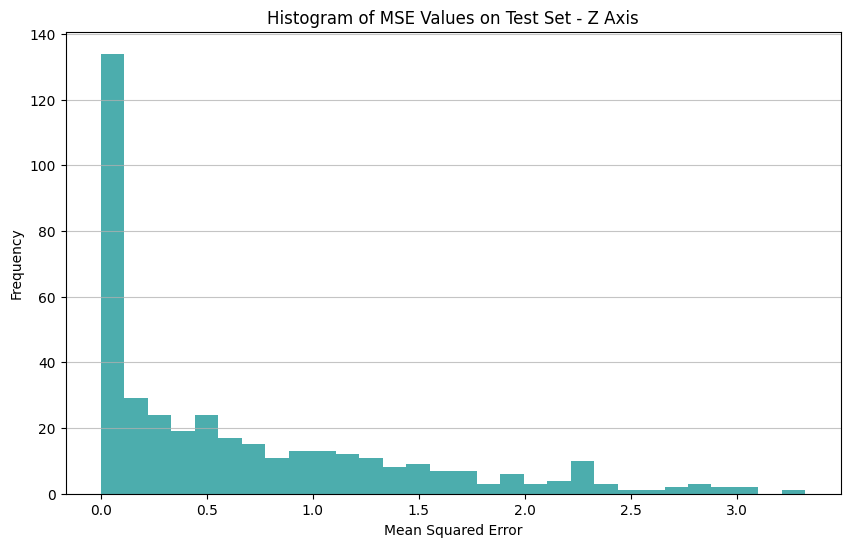

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# import torch

# # Set model to evaluation mode
# model.eval()

# # Lists to store MAE and MSE values for each axis
# mae_values_x, mae_values_y, mae_values_z = [], [], []
# mse_values_x, mse_values_y, mse_values_z = [], [], []

# with torch.no_grad():  # Disable gradients for efficiency
#     for batch_data in test_loader:
#         pCT_test, rCT_test = batch_data["plan"].to(device), batch_data["repeat"].to(device)
#         reg_test = batch_data["pos"].to(device)  # Ground truth coordinates
#         output_test = model(pCT_test, rCT_test)

#         # Calculate MAE and MSE for each axis
#         mae_x = torch.abs(output_test[:, 0] - reg_test[:, 0])
#         mae_y = torch.abs(output_test[:, 1] - reg_test[:, 1])
#         mae_z = torch.abs(output_test[:, 2] - reg_test[:, 2])
        
#         mse_x = (output_test[:, 0] - reg_test[:, 0]) ** 2
#         mse_y = (output_test[:, 1] - reg_test[:, 1]) ** 2
#         mse_z = (output_test[:, 2] - reg_test[:, 2]) ** 2

#         # Append to lists
#         mae_values_x.extend(mae_x.cpu().numpy())
#         mae_values_y.extend(mae_y.cpu().numpy())
#         mae_values_z.extend(mae_z.cpu().numpy())

#         mse_values_x.extend(mse_x.cpu().numpy())
#         mse_values_y.extend(mse_y.cpu().numpy())
#         mse_values_z.extend(mse_z.cpu().numpy())

# # Function to plot histograms
# def plot_histogram(values, title, xlabel, ylabel='Frequency', color='indigo' ):
#     plt.figure(figsize=(10, 6))
#     plt.hist(values, bins=30, color=color, alpha=0.7)
#     plt.title(title)
#     plt.xlabel(xlabel)
#     plt.ylabel(ylabel)
#     plt.grid(axis='y', alpha=0.75)
#     plt.show()

# # Plotting the histograms
# plot_histogram(mae_values_x, 'Histogram of MAE Values on Test Set - X Axis', 'Mean Absolute Error')
# plot_histogram(mae_values_y, 'Histogram of MAE Values on Test Set - Y Axis', 'Mean Absolute Error')
# plot_histogram(mae_values_z, 'Histogram of MAE Values on Test Set - Z Axis', 'Mean Absolute Error')

# plot_histogram(mse_values_x, 'Histogram of MSE Values on Test Set - X Axis', 'Mean Squared Error', color='darkcyan')
# plot_histogram(mse_values_y, 'Histogram of MSE Values on Test Set - Y Axis', 'Mean Squared Error', color='darkcyan')
# plot_histogram(mse_values_z, 'Histogram of MSE Values on Test Set - Z Axis', 'Mean Squared Error', color='darkcyan')


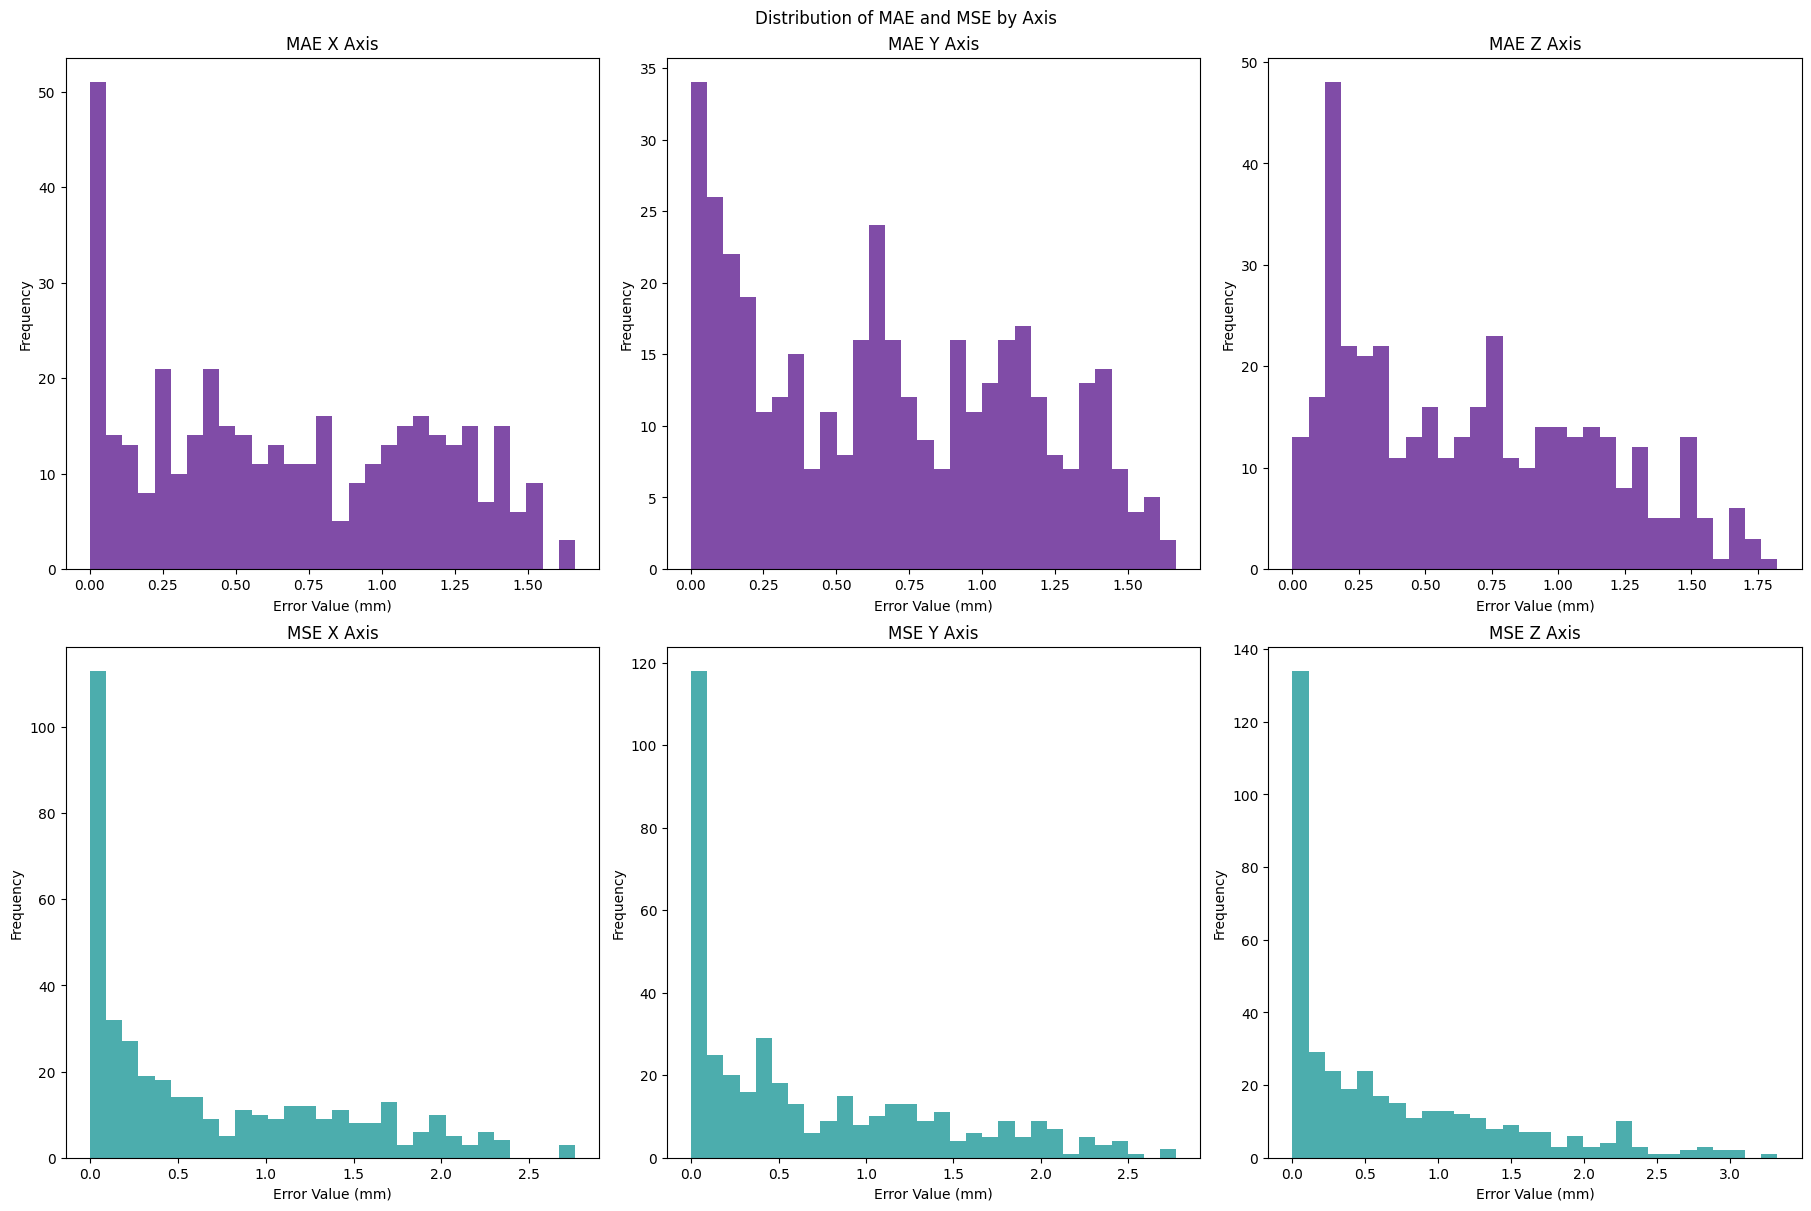

In [ ]:
import matplotlib.pyplot as plt
import torch
from torch.nn.functional import mse_loss, l1_loss

# Setup
model.eval()  # Evaluation mode
mae_x, mae_y, mae_z = [], [], []  # Lists to store MAE for each axis
mse_x, mse_y, mse_z = [], [], []  # Lists to store MSE for each axis

with torch.no_grad():
    for batch_data in test_loader:
        pCT_test, rCT_test = batch_data["plan"].to(device), batch_data["repeat"].to(device)
        reg_test = batch_data["pos"].to(device)

        output_test = model(pCT_test, rCT_test)

        # Calculate MAE and MSE for each axis and store
        mae_values = torch.abs(output_test - reg_test)
        mse_values = (output_test - reg_test) ** 2
        
        mae_x.extend(mae_values[:, 0].cpu().numpy())
        mae_y.extend(mae_values[:, 1].cpu().numpy())
        mae_z.extend(mae_values[:, 2].cpu().numpy())
        
        mse_x.extend(mse_values[:, 0].cpu().numpy())
        mse_y.extend(mse_values[:, 1].cpu().numpy())
        mse_z.extend(mse_values[:, 2].cpu().numpy())



# Plotting
fig, axs = plt.subplots(2, 3, figsize=(18, 12), constrained_layout=True)
fig.suptitle('Distribution of MAE and MSE by Axis')

# Define histogram plotting function
def plot_histogram(ax, data, title, color):
    ax.hist(data, bins=30, color=color, alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel('Error Value (mm)')
    ax.set_ylabel('Frequency')

# MAE histograms
plot_histogram(axs[0, 0], mae_x, 'MAE X Axis', 'indigo')
plot_histogram(axs[0, 1], mae_y, 'MAE Y Axis', 'indigo')
plot_histogram(axs[0, 2], mae_z, 'MAE Z Axis', 'indigo')

# MSE histograms
plot_histogram(axs[1, 0], mse_x, 'MSE X Axis', 'darkcyan')
plot_histogram(axs[1, 1], mse_y, 'MSE Y Axis', 'darkcyan')
plot_histogram(axs[1, 2], mse_z, 'MSE Z Axis', 'darkcyan')

plt.show()



In [ ]:
import torch
from torch.nn.functional import mse_loss, l1_loss  # l1_loss is MAE

# Assuming `test_loader` and `model` are already defined
model.eval()  # Set model to evaluation mode
total_mae = 0.0
total_mse = 0.0
total_samples = 0

with torch.no_grad():  # No need to calculate gradients during evaluation
    for batch_data in test_loader:
        pCT_test, rCT_test = batch_data["plan"].to(device), batch_data["repeat"].to(device)
        reg_test = batch_data["pos"].to(device)  # Ground truth coordinates

        output_test = model(pCT_test, rCT_test)

        # Calculate MAE
        mae = l1_loss(output_test, reg_test, reduction='sum')  # Summing to calculate total MAE later
        total_mae += mae.item()

        # Calculate MSE
        mse = mse_loss(output_test, reg_test, reduction='sum')  # Summing to calculate total MSE later
        total_mse += mse.item()

        total_samples += pCT_test.size(0)
    
    # Calculate average MAE and MSE across all test samples
    average_mae = total_mae / total_samples
    average_mse = total_mse / total_samples
    print(f"Average MAE on Test Set: {average_mae}")
    print(f"Average MSE on Test Set: {average_mse}")


Average MAE on Test Set: 2.023834460126567
Average MSE on Test Set: 2.0262423639155


In [ ]:
import torch
import numpy as np

# Set model to evaluation mode
model.eval()
total_distance = 0.0
total_samples = 0

with torch.no_grad():  # No need to calculate gradients during evaluation
    for batch_data in test_loader:
        # Load data
        pCT_test, rCT_test = batch_data["plan"].to(device), batch_data["repeat"].to(device)
        reg_test = batch_data["pos"].to(device)  # Ground truth coordinates
        
        # Model prediction
        output_test = model(pCT_test, rCT_test)
        # print(output_test)
        # Calculate Euclidean distance between output and ground truth
        distance = torch.sqrt(torch.sum((output_test - reg_test) ** 2, dim=1))
        total_distance += distance.sum().item()
        total_samples += distance.size(0)
    
    # Calculate average distance across all test samples
    average_distance = total_distance / total_samples
    print(f"Average Euclidean Distance on Test Set: {average_distance}")


Average Euclidean Distance on Test Set: 1.2872556024301929


In [ ]:
import torch

# Set model to evaluation mode
model.eval()
total_distance_x = 0.0
total_distance_y = 0.0
total_distance_z = 0.0
total_samples = 0

with torch.no_grad():  # Disable gradient computation for evaluation
    for batch_data in test_loader:
        # Load test data
        pCT_test, rCT_test = batch_data["plan"].to(device), batch_data["repeat"].to(device)
        reg_test = batch_data["pos"].to(device)  # Ground truth coordinates
        
        # Get model predictions
        output_test = model(pCT_test, rCT_test)
        
        # Calculate Euclidean distance for each axis separately
        distance_x = torch.abs(output_test[:, 0] - reg_test[:, 0])
        distance_y = torch.abs(output_test[:, 1] - reg_test[:, 1])
        distance_z = torch.abs(output_test[:, 2] - reg_test[:, 2])
        
        total_distance_x += distance_x.sum().item()
        total_distance_y += distance_y.sum().item()
        total_distance_z += distance_z.sum().item()
        total_samples += distance_x.size(0)  # Assuming batch size is consistent across all dimensions
    
    # Calculate average distance for each axis across all test samples
    average_distance_x = total_distance_x / total_samples
    average_distance_y = total_distance_y / total_samples
    average_distance_z = total_distance_z / total_samples
    print(f"Average Distance on Test Set - X Axis: {average_distance_x}")
    print(f"Average Distance on Test Set - Y Axis: {average_distance_y}")
    print(f"Average Distance on Test Set - Z Axis: {average_distance_z}")


Average Distance on Test Set - X Axis: 0.6900613039807619
Average Distance on Test Set - Y Axis: 0.6753595152510529
Average Distance on Test Set - Z Axis: 0.6578509989123659


In [ ]:
# Evaluate the model on the test set
model.eval()
test_loss = []
with torch.no_grad():
    for batch_data in val_loader:
        pCT_test, rCT_test = batch_data["plan"].to(device), batch_data["repeat"].to(device)
        reg_test = batch_data["pos"].clone().detach().requires_grad_(True).to(device)  # If gradients are required for 'reg'

        output_test = model(pCT_test, rCT_test)
        loss_test = mae_loss(output_test, reg_test)

        test_loss.append(loss_test.item())

mean_test_loss = np.mean(test_loss)
print(f'Loss for validation set: {mean_test_loss:.4f}')

Loss for validation set: 0.6679


In [ ]:
import torch
import numpy as np

# Initialize accumulators
distances_x = []
distances_y = []
distances_z = []

model.eval()  # Set model to evaluation mode
with torch.no_grad():  # No need for gradient computation
    for batch_data in test_loader:
        pCT_test, rCT_test = batch_data["plan"].to(device), batch_data["repeat"].to(device)
        reg_test = batch_data["pos"].to(device)  # Ground truth coordinates

        output_test = model(pCT_test, rCT_test)

        # Compute absolute differences for each axis
        distance_x = torch.abs(output_test[:, 0] - reg_test[:, 0])
        distance_y = torch.abs(output_test[:, 1] - reg_test[:, 1])
        distance_z = torch.abs(output_test[:, 2] - reg_test[:, 2])

        # Collect distances
        distances_x.extend(distance_x.cpu().numpy())
        distances_y.extend(distance_y.cpu().numpy())
        distances_z.extend(distance_z.cpu().numpy())

# Convert lists to numpy arrays for statistical analysis
distances_x = np.array(distances_x)
distances_y = np.array(distances_y)
distances_z = np.array(distances_z)

# Calculate mean and standard deviation for each axis
mean_x, sigma_x = np.mean(distances_x), np.std(distances_x)
mean_y, sigma_y = np.mean(distances_y), np.std(distances_y)
mean_z, sigma_z = np.mean(distances_z), np.std(distances_z)

# Print results
print(f"X Axis: Mean = {mean_x:.2f}, Sigma = {sigma_x:.2f}, Range = Mean ± Sigma = [{mean_x-sigma_x:.2f}, {mean_x+sigma_x:.2f}]")
print(f"Y Axis: Mean = {mean_y:.2f}, Sigma = {sigma_y:.2f}, Range = Mean ± Sigma = [{mean_y-sigma_y:.2f}, {mean_y+sigma_y:.2f}]")
print(f"Z Axis: Mean = {mean_z:.2f}, Sigma = {sigma_z:.2f}, Range = Mean ± Sigma = [{mean_z-sigma_z:.2f}, {mean_z+sigma_z:.2f}]")


X Axis: Mean = 0.68, Sigma = 0.47, Range = Mean ± Sigma = [0.20, 1.15]
Y Axis: Mean = 0.68, Sigma = 0.47, Range = Mean ± Sigma = [0.21, 1.14]
Z Axis: Mean = 0.67, Sigma = 0.46, Range = Mean ± Sigma = [0.21, 1.14]




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



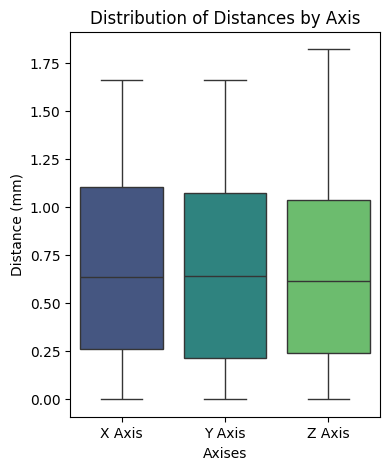

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming distances_x, distances_y, distances_z are numpy arrays from the previous step

# Create a DataFrame for easier plotting
data = {
    'X Axis': distances_x,
    'Y Axis': distances_y,
    'Z Axis': distances_z
}
df_distances = pd.DataFrame(data)

# Melt the DataFrame to long-format for seaborn
df_long = pd.melt(df_distances, var_name='Axis', value_name='Distance')

# Plotting
plt.figure(figsize=(4, 5))
sns.boxplot(x='Axis', y='Distance', data=df_long, palette='viridis', showfliers=True)
plt.title('Distribution of Distances by Axis')
plt.ylabel('Distance (mm)')
plt.xlabel('Axises')

# Show plot
plt.show()


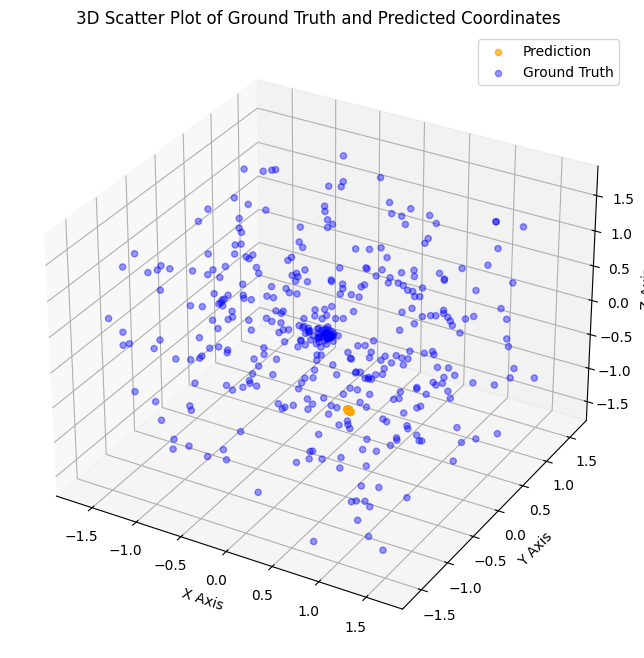

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Accumulate all ground truth and predictions for plotting
all_gt = []  # For storing all ground truth coordinates
all_pred = []  # For storing all prediction coordinates

model.eval()  # Ensure model is in evaluation mode
with torch.no_grad():  # No gradients needed
    for batch_data in test_loader:
        pCT, rCT = batch_data["plan"].to(device), batch_data["repeat"].to(device)
        reg = batch_data["pos"].to(device)  # Ground truth coordinates
        
        output = model(pCT, rCT)  # Model predictions
        
        # Collect coordinates
        all_gt.append(reg.cpu().numpy())
        all_pred.append(output.cpu().numpy())

# Convert lists to numpy arrays
all_gt = np.concatenate(all_gt) 
all_pred = np.concatenate(all_pred)  



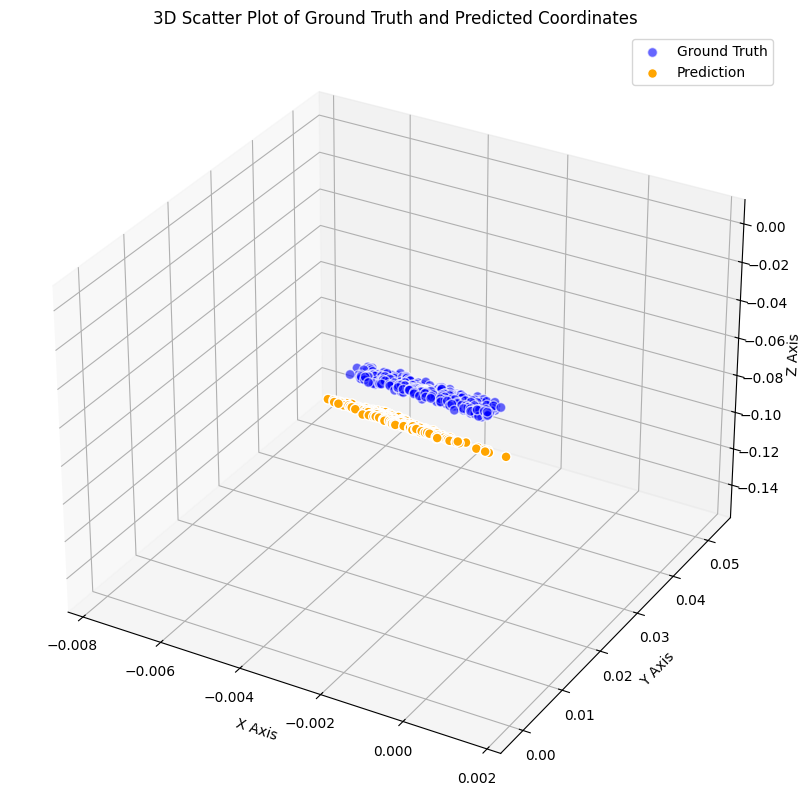

In [ ]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# import numpy as np

# # Assuming all_gt and all_pred are already defined and populated

# # Creating a 3D scatter plot with emphasis on all points
# fig = plt.figure(figsize=(12, 10))
# ax = fig.add_subplot(111, projection='3d')

# # Ground truth coordinates in blue, with slightly larger marker size
# ax.scatter(all_gt[:, 0]/1000, all_gt[:, 1]/1000, all_gt[:, 2]/1000, color='blue', alpha=0.6, edgecolor='w', s=50, label='Ground Truth')

# # Predicted coordinates in orange, with slightly larger marker size
# ax.scatter(all_pred[:, 0], all_pred[:, 1], all_pred[:, 2], color='orange', alpha=1.0, edgecolor='w', s=50, label='Prediction')

# # Labeling axes
# ax.set_xlabel('X Axis')
# ax.set_ylabel('Y Axis')
# ax.set_zlabel('Z Axis')
# ax.set_title('3D Scatter Plot of Ground Truth and Predicted Coordinates')
# ax.legend()

# plt.show()


Ground Truth: [-0.23526096 -0.5167086  -0.7067507 ]
Coordination predicted by model: [1252.8829  401.6379 1157.0521]


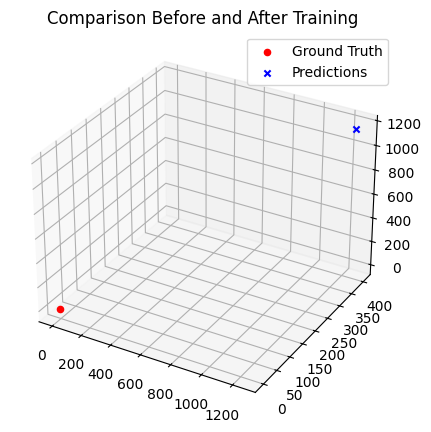

In [ ]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# from monai.transforms import LoadImaged
# from monai.data.image_reader import ITKReader

# load_image = LoadImaged(keys=["plan", "repeat"], reader=ITKReader())
# sample_data = test_data[0]  

# sample_data = load_image(sample_data)
# pCT = sample_data["plan"].unsqueeze(0).unsqueeze(0).to(device)
# rCT = sample_data["repeat"].unsqueeze(0).unsqueeze(0).to(device)
# ground_truth = sample_data["pos"]
# print("Ground Truth:", ground_truth)

# model.eval()
# with torch.no_grad():
#     prediction = model(pCT, rCT)
# prediction = prediction[0].cpu().numpy()
# print("Coordination predicted by model:", prediction)

# # Plot ground truth and predictions
# fig = plt.figure(figsize=(10, 5))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(ground_truth[0], ground_truth[1], ground_truth[2], c='r', marker='o', label='Ground Truth')
# ax.scatter(prediction[0], prediction[1], prediction[2], c='b', marker='x', label='Predictions')

# ax.set_title('Comparison Before and After Training')
# ax.legend()

# plt.show()


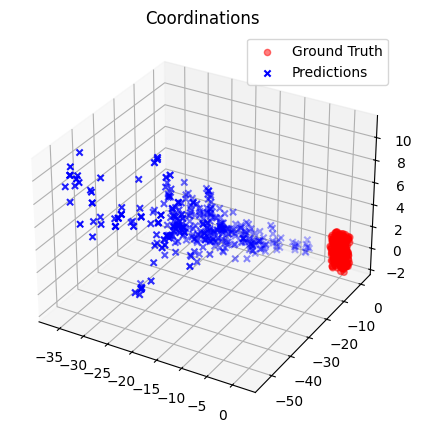

In [ ]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# from monai.transforms import LoadImaged
# from monai.data.image_reader import ITKReader

# # Function to plot ground truth and predictions
# def plot_samples(test_files, model, device):
#     all_ground_truth = []
#     all_predictions = []

#     for sample_data in test_files:
#         sample_data = load_image(sample_data)
#         pCT = sample_data["plan"].unsqueeze(0).unsqueeze(0).to(device)
#         rCT = sample_data["repeat"].unsqueeze(0).unsqueeze(0).to(device)
#         ground_truth = sample_data["pos"]
        

#         model.eval()
#         with torch.no_grad():
#             prediction = model(pCT, rCT)
#         prediction = prediction[0].cpu().numpy()
        

#         all_ground_truth.append(ground_truth)
#         all_predictions.append(prediction)

#     # Plot all ground truth and predictions in a single 3D plot
#     fig = plt.figure(figsize=(10, 5))
#     ax = fig.add_subplot(111, projection='3d')

#     # Scatter plot for ground truth
#     all_ground_truth = np.array(all_ground_truth)
#     # print(all_ground_truth)
#     ax.scatter(all_ground_truth[:, 0], all_ground_truth[:, 1], all_ground_truth[:, 2], c='r', alpha = 0.5, label='Ground Truth')

#     # Scatter plot for predictions
#     all_predictions = np.array(all_predictions)
#     ax.scatter(all_predictions[:, 0]/100, all_predictions[:, 1]/100, all_predictions[:, 2]/100, c='b', marker='x', label='Predictions')

#     ax.set_title('Coordinations')
#     ax.legend()

#     plt.show()


# # Plot all ground truth and predictions in a single 3D plot
# plot_samples(test_data, model, device)


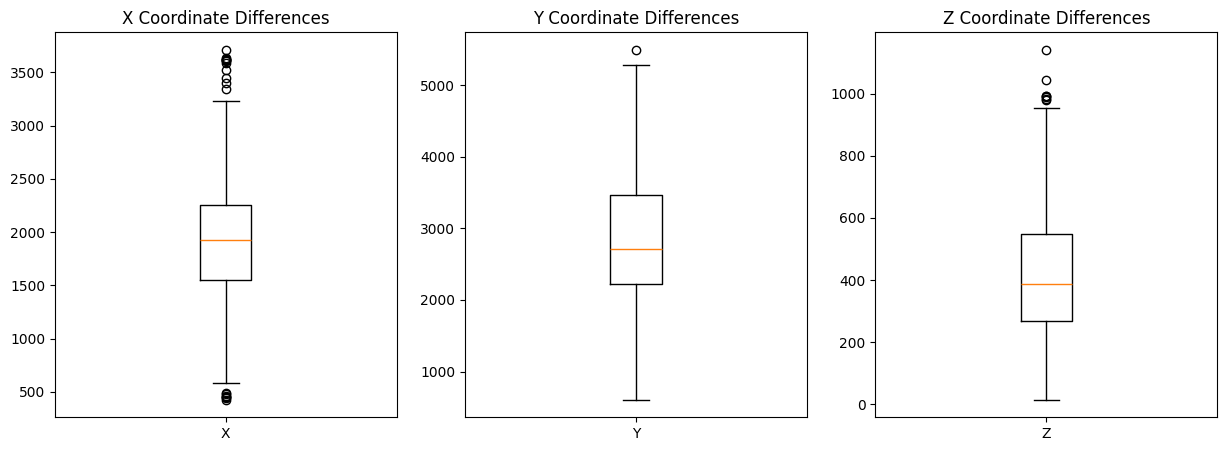

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# from monai.transforms import LoadImaged
# from monai.data.image_reader import ITKReader

# # Lists to store differences for each coordinate
# x_diffs, y_diffs, z_diffs = [], [], []

# # Iterate through all test samples
# for sample_data in test_data:
#     load_image = LoadImaged(keys=["plan", "repeat"], reader=ITKReader())
#     sample_data = load_image(sample_data)

#     pCT = sample_data["plan"].unsqueeze(0).unsqueeze(0).to(device)
#     rCT = sample_data["repeat"].unsqueeze(0).unsqueeze(0).to(device)
#     ground_truth = sample_data["pos"]
    
#     # Get the model prediction
#     model.eval()
#     with torch.no_grad():
#         prediction = model(pCT, rCT)
#         prediction = prediction[0].cpu().numpy()

#         # Calculate differences
#         x_diff = np.abs(ground_truth[0] - prediction[0])
#         y_diff = np.abs(ground_truth[1] - prediction[1])
#         z_diff = np.abs(ground_truth[2] - prediction[2])

#         # Append differences to the lists
#         x_diffs.append(x_diff)
#         y_diffs.append(y_diff)
#         z_diffs.append(z_diff)

# # Create box plots
# fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# axes[0].boxplot(x_diffs, labels=['X'])
# axes[0].set_title('X Coordinate Differences')

# axes[1].boxplot(y_diffs, labels=['Y'])
# axes[1].set_title('Y Coordinate Differences')

# axes[2].boxplot(z_diffs, labels=['Z'])
# axes[2].set_title('Z Coordinate Differences')

# plt.show()
